In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import math, os

DATA_PATH = "dano_dataset_avia_hashed_corrected_s.xlsx"  # файл рядом с ноутбуком
df = pd.read_excel(DATA_PATH, engine="openpyxl")

df["session_start_dt"] = pd.to_datetime(df["session_start_dt"])
df["screen_dttm"] = pd.to_datetime(df["screen_dttm"])

df.shape, df.columns

((244345, 22),
 Index(['session_start_dt', 'device_platform', 'client_start_year', 'client_id',
        'session_id', 'session_source', 'session_channel', 'screen_nm',
        'screen_dttm', 'client_avia_user_start_year', 'client_segment',
        'client_avia_orders', 'client_gmv', 'session_purchase_price',
        'session_purchase_tickets_num', 'session_purchase_tickets_sourse',
        'session_purchase_status', 'session_purchase_tickets_airline',
        'session_purchase_tickets_departure',
        'session_purchase_tickets_arrival',
        'session_purchase_tickets_luggage_flg',
        'session_purchase_tickets_class_of_service'],
       dtype='object'))

In [84]:
n_rows = len(df)
n_sessions = df["session_id"].nunique()
n_clients = df["client_id"].nunique()

print("Строк:", n_rows)
print("Сессий:", n_sessions)
print("Клиентов:", n_clients)
print("\nЭкранов:", df["screen_nm"].unique())

Строк: 244345
Сессий: 38561
Клиентов: 1900

Экранов: ['Оффер' 'Выдача' 'Поиск' 'Чекаут' 'Покупка бэк' 'Покупка фронт']


In [53]:
steps = ["Поиск","Выдача","Оффер","Чекаут","Покупка фронт","Покупка бэк"]

# Какие экраны были в каждой сессии
sess_steps = df.groupby("session_id")["screen_nm"].agg(lambda s: set(s.dropna()))

ind = pd.DataFrame(index=sess_steps.index)
for st in steps:
    ind[st] = sess_steps.apply(lambda x: st in x)

# Успешная покупка (в данных заполнено только для успешных)
ind["purchase_success"] = df.groupby("session_id")["session_purchase_status"].apply(lambda s: (s=="Успешные").any())

def first_nonnull(x):
    x = x.dropna()
    return x.iloc[0] if len(x) else np.nan

sess_attr = df.sort_values("screen_dttm").groupby("session_id").agg({
    "client_id":"first",
    "session_start_dt":"first",
    "device_platform": first_nonnull,
    "session_source": first_nonnull,
    "session_channel": first_nonnull,
    "client_segment": first_nonnull,
    "client_gmv": first_nonnull,
    "client_avia_orders": first_nonnull,
})

sess = pd.concat([sess_attr, ind], axis=1)
sess.head()

,client_id,session_start_dt,device_platform,session_source,session_channel,client_segment,client_gmv,client_avia_orders,Поиск,Выдача,Оффер,Чекаут,Покупка фронт,Покупка бэк,purchase_success
session_id,,,,,,,,,,,,,,,
0003e714a683cdd96f098127aff681dd2cfc33b402f15c2f129bb12c2f63c1a0,e20c6a7e9edb9cd2da16309c80999aff4691c9a0cc0dbd...,2025-06-08,ios,Неизвестно,Неизвестно,5,5134.000000,1,True,True,True,False,False,False,False
0004590013d511b721ed2f3c7cf88d7377afec5f9e16ffc5d9120224df2c9629,8bc309627257bcbe70655ed10c0f4a36caca415ae955a8...,2025-08-15,ios,Контент-каналы,Сторис,3,18021.140000,2,False,True,True,False,False,False,False
0004d971d223354a155ff270b78afb6b0eb1625e4a50c1f7196051fe55231157,8df8b021c73e170db4098e3a60832897ce15552cdc9711...,2025-04-19,android,Контент-каналы,Сторис,5,16169.040000,1,True,True,True,True,False,False,False
00055a6d1aad9546070df10bfaa055e37cf4bf3e0c20d86001583d2f3b4328a0,d73bbcb639408102d0f1440e4be774cffabcb7d3388d64...,2025-01-27,ios,SEO,Яндекс,1,40671.371333,15,True,True,True,False,False,False,False
0007d378c226ba72c602bd8fab24ec05ad41d26931abbeb81da3026cec62c523,de87053dcf30a831d4d6381bc2308313023d2108e715cf...,2025-09-13,ios,Неизвестно,Неизвестно,5,25521.400000,1,True,True,False,False,False,False,False


In [54]:
sess["month"] = sess["session_start_dt"].dt.to_period("M").dt.to_timestamp()

monthly = sess.groupby("month").agg(
    sessions=("purchase_success","count"),
    purchases=("purchase_success","sum")
)
monthly["conversion"] = monthly["purchases"]/monthly["sessions"]
monthly

,sessions,purchases,conversion
month,,,
2025-01-01,4784,394,0.082358
2025-02-01,4004,264,0.065934
2025-03-01,4374,294,0.067215
2025-04-01,4475,280,0.062570
2025-05-01,4659,283,0.060743
2025-06-01,4575,264,0.057705
2025-07-01,4061,82,0.020192
2025-08-01,4390,293,0.066743
2025-09-01,3239,210,0.064835


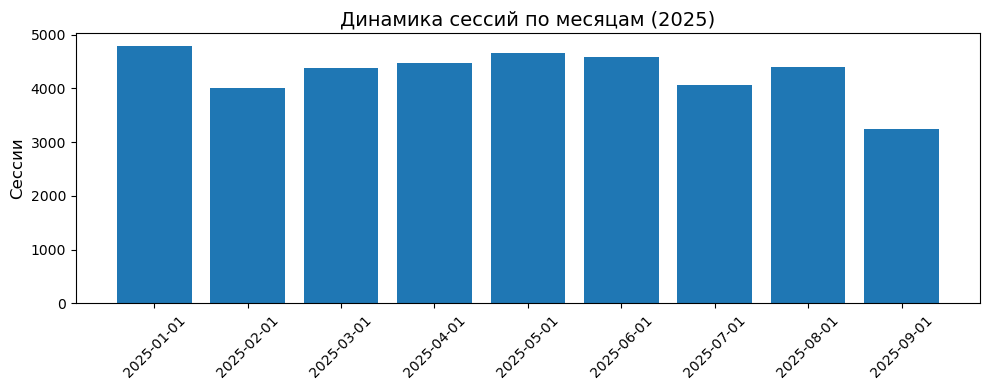

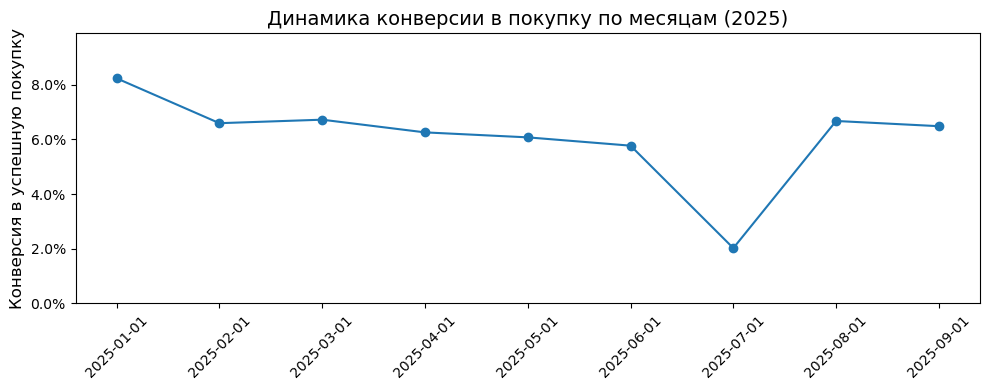

In [85]:
x = monthly.index.astype(str)

# 1) Сессии по месяцам
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(x, monthly["sessions"])
ax.set_ylabel("Сессии")
ax.set_title("Динамика сессий по месяцам (2025)")
ax.tick_params(axis="x", rotation=45)
fig.tight_layout()
plt.show()

# 2) Конверсия в покупку по месяцам
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, monthly["conversion"], marker="o")
ax.set_ylabel("Конверсия в успешную покупку")
ax.set_title("Динамика конверсии в покупку по месяцам (2025)")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylim(0, monthly["conversion"].max() * 1.2)
ax.tick_params(axis="x", rotation=45)
fig.tight_layout()
plt.show()

In [56]:
funnel_steps = ["Поиск","Выдача","Оффер","Чекаут","purchase_success"]
step_names = ["Поиск","Выдача","Оффер","Чекаут","Успешная покупка"]

n_sessions = len(sess)
funnel_counts = [int(sess[st].sum()) for st in funnel_steps]
funnel_rates = [c/n_sessions for c in funnel_counts]
step_to_next = [funnel_counts[i+1]/funnel_counts[i] for i in range(len(funnel_counts)-1)] + [np.nan]

funnel_table = pd.DataFrame({
    "Шаг": step_names,
    "Сессий": funnel_counts,
    "Доля от всех сессий": funnel_rates,
    "Конверсия в следующий шаг": step_to_next
})
funnel_table

,Шаг,Сессий,Доля от всех сессий,Конверсия в следующий шаг
0,Поиск,37756,0.979124,0.909101
1,Выдача,34324,0.890122,0.515936
2,Оффер,17709,0.459246,0.365294
3,Чекаут,6469,0.167760,0.365435
4,Успешная покупка,2364,0.061305,NaN


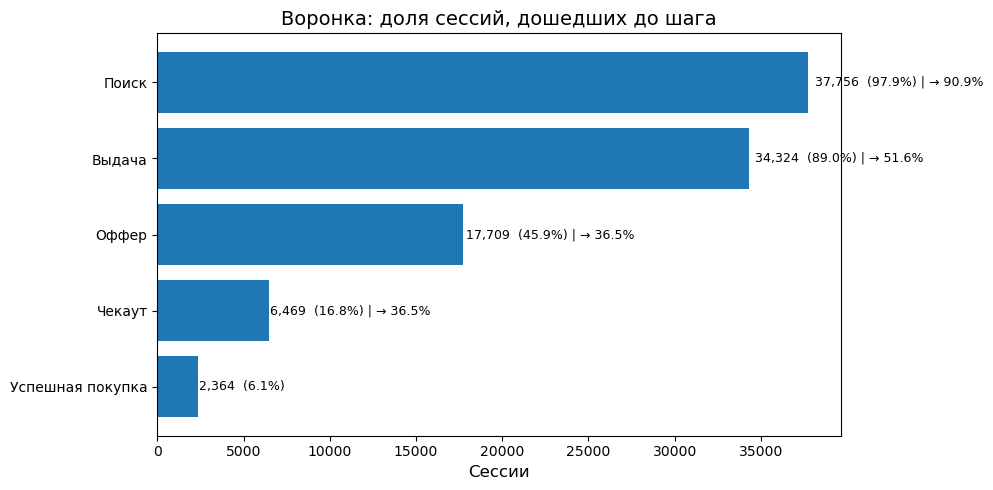

In [57]:
ft = funnel_table.copy()
ft["Доля от всех сессий"] *= 100
ft["Конверсия в следующий шаг"] *= 100

fig, ax = plt.subplots(figsize=(10,5))
ax.barh(ft["Шаг"], ft["Сессий"])
ax.invert_yaxis()
ax.set_xlabel("Сессии")
ax.set_title("Воронка: доля сессий, дошедших до шага")

for i,(cnt,share,conv) in enumerate(zip(ft["Сессий"], ft["Доля от всех сессий"], ft["Конверсия в следующий шаг"])):
    label = f"{cnt:,}  ({share:.1f}%)"
    if not math.isnan(conv):
        label += f" | → {conv:.1f}%"
    ax.text(cnt*1.01, i, label, va="center", fontsize=9)

fig.tight_layout()
plt.show()

In [58]:
seg_table = (sess.groupby("client_segment")["purchase_success"]
             .agg(Сессий="count", Конверсия="mean")
             .sort_values("Конверсия", ascending=False))
seg_table

,Сессий,Конверсия
client_segment,,
4,13938,0.071818
2,13766,0.064507
1,1367,0.055596
5,4968,0.053543
3,3777,0.033889
6,745,0.006711


In [65]:
# Время в datetime
df["screen_dttm"] = pd.to_datetime(df["screen_dttm"], errors="coerce")

# Маппинг экранов на этапы воронки
stage_map = {
    "Поиск": "Поиск",
    "Выдача": "Выдача",
    "Оффер": "Оффер",
    "Чекаут": "Чекаут",
    "Покупка фронт": "Покупка",
    "Покупка бэк": "Покупка",
}
df["stage"] = df["screen_nm"].map(stage_map)

# Оставляем только этапы воронки
stages_order = ["Поиск", "Выдача", "Оффер", "Чекаут", "Покупка"]
df_f = df[df["stage"].isin(stages_order)].dropna(subset=["session_id", "stage", "screen_dttm"]).copy()

# Берем первый момент попадания на каждый этап в рамках сессии
first_ts = (df_f.groupby(["session_id", "stage"])["screen_dttm"]
              .min()
              .unstack())

# Считаем дельты между соседними этапами
steps = [("Поиск", "Выдача"),
         ("Выдача", "Оффер"),
         ("Оффер", "Чекаут"),
         ("Чекаут", "Покупка")]

rows = []
for a, b in steps:
    delta_min = (first_ts[b] - first_ts[a]).dt.total_seconds() / 60
    tmp = pd.DataFrame({
        "session_id": first_ts.index,
        "step": f"{a} → {b}",
        "minutes": delta_min
    })
    # оставляем только валидные (положительные) длительности
    tmp = tmp[np.isfinite(tmp["minutes"]) & (tmp["minutes"] > 0)]
    rows.append(tmp)

dur = pd.concat(rows, ignore_index=True)

# (опционально) отрежем дикие хвосты, чтобы графики были читаемыми
cap = dur["minutes"].quantile(0.99)
dur["minutes_capped"] = dur["minutes"].clip(upper=cap)

# Быстрые сводки
summary = (dur.groupby("step")["minutes"]
             .agg(n="count",
                  median="median",
                  mean="mean",
                  p75=lambda x: x.quantile(0.75),
                  p90=lambda x: x.quantile(0.90))
             .reset_index())

summary

,step,n,median,mean,p75,p90
0,Выдача → Оффер,17691,0.754700,10.619474,2.233292,13.819100
1,Оффер → Чекаут,6398,0.488800,18.217856,3.767379,45.390818
2,Поиск → Выдача,33273,0.389300,1.433662,0.652683,1.065033
3,Чекаут → Покупка,2412,5.739125,30.311813,18.148412,85.644300


In [71]:
df = df.copy()
df["screen_dttm"] = pd.to_datetime(df["screen_dttm"], errors="coerce")

stage_map = {
    "Поиск": "Поиск",
    "Выдача": "Выдача",
    "Оффер": "Оффер",
    "Чекаут": "Чекаут",
    "Покупка фронт": "Покупка",
    "Покупка бэк": "Покупка",
}
df["stage"] = df["screen_nm"].map(stage_map)

stages = ["Поиск","Выдача","Оффер","Чекаут","Покупка"]
d = df[df["stage"].isin(stages)].dropna(subset=["session_id","screen_dttm","stage"]).copy()
d = d.sort_values(["session_id","screen_dttm"])

# время окончания сессии = последний эвент в сессии
session_end = d.groupby("session_id")["screen_dttm"].max()

# следующий эвент по времени внутри сессии
d["next_stage"] = d.groupby("session_id")["stage"].shift(-1)
d["next_time"]  = d.groupby("session_id")["screen_dttm"].shift(-1)

# для каждого session_id берём "Выдача": начало = первая выдача, конец = первый переход на другой stage после выдачи (или конец сессии)
disp = d[d["stage"] == "Выдача"].copy()

start_disp = disp.groupby("session_id")["screen_dttm"].min()

# момент выхода из выдачи = минимальный next_time там, где next_stage != 'Выдача'
exit_times = (disp.loc[disp["next_stage"].ne("Выдача") & disp["next_time"].notna()]
                .groupby("session_id")["next_time"].min())

end_disp = exit_times.reindex(start_disp.index).fillna(session_end.reindex(start_disp.index))

dur_disp_min = (end_disp - start_disp).dt.total_seconds() / 60

out = pd.DataFrame({
    "session_id": start_disp.index,
    "disp_minutes": dur_disp_min
})

# исходы: дошли до оффера? купили?
has_offer = d.groupby("session_id")["stage"].apply(lambda s: (s == "Оффер").any())
has_purchase = d.groupby("session_id")["stage"].apply(lambda s: (s == "Покупка").any())

out["reached_offer"] = out["session_id"].map(has_offer).fillna(False)
out["purchased"] = out["session_id"].map(has_purchase).fillna(False)

# Оставим только адекватные длительности (например до 99 перцентиля)
cap = out["disp_minutes"].quantile(0.99)
out["disp_minutes_capped"] = out["disp_minutes"].clip(upper=cap)

out.head()

,session_id,disp_minutes,reached_offer,purchased,disp_minutes_capped
session_id,,,,,
0003e714a683cdd96f098127aff681dd2cfc33b402f15c2f129bb12c2f63c1a0,0003e714a683cdd96f098127aff681dd2cfc33b402f15c...,5.377650,True,False,5.377650
0004590013d511b721ed2f3c7cf88d7377afec5f9e16ffc5d9120224df2c9629,0004590013d511b721ed2f3c7cf88d7377afec5f9e16ff...,0.176950,True,False,0.176950
0004d971d223354a155ff270b78afb6b0eb1625e4a50c1f7196051fe55231157,0004d971d223354a155ff270b78afb6b0eb1625e4a50c1...,1.953533,True,False,1.953533
00055a6d1aad9546070df10bfaa055e37cf4bf3e0c20d86001583d2f3b4328a0,00055a6d1aad9546070df10bfaa055e37cf4bf3e0c20d8...,0.656683,True,False,0.656683
0007d378c226ba72c602bd8fab24ec05ad41d26931abbeb81da3026cec62c523,0007d378c226ba72c602bd8fab24ec05ad41d26931abbe...,1.719883,False,False,1.719883


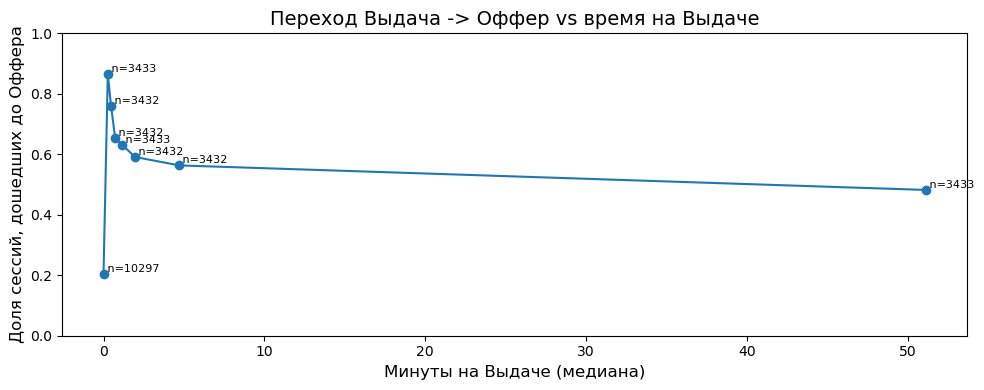

In [76]:
tmp = out.dropna(subset=["disp_minutes_capped"]).copy()

tmp["bin"] = pd.qcut(tmp["disp_minutes_capped"], q=10, duplicates="drop")

g = (tmp.groupby("bin", observed=True)
       .agg(n=("session_id","count"),
            offer_rate=("reached_offer","mean"),
            median_minutes=("disp_minutes_capped","median"))
       .reset_index())

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(g["median_minutes"], g["offer_rate"], marker="o")
ax.set_title("Переход Выдача -> Оффер vs время на Выдаче")
ax.set_xlabel("Минуты на Выдаче (медиана)")
ax.set_ylabel("Доля сессий, дошедших до Оффера")
ax.set_ylim(0, 1)

for x, y, n in zip(g["median_minutes"], g["offer_rate"], g["n"]):
    ax.text(x, y, f" n={n}", va="bottom", ha="left", fontsize=8)

fig.tight_layout()
plt.show()

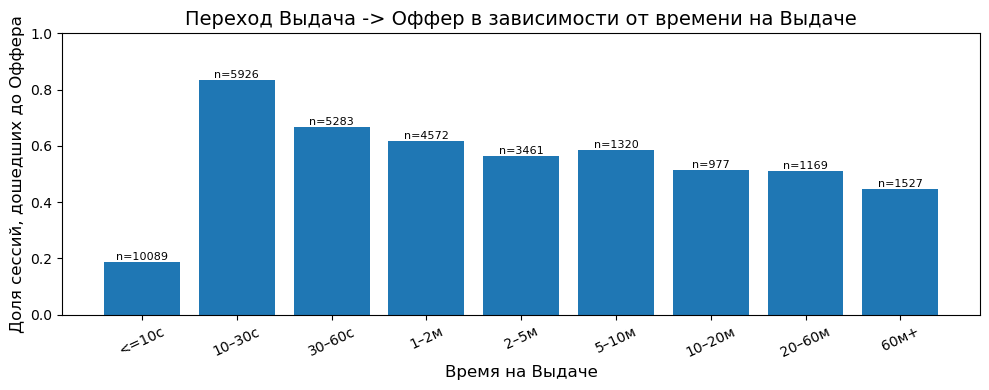

In [83]:
tmp = out.dropna(subset=["disp_minutes"]).copy()

# фиксированные интервалы (в минутах)
bins = [-0.001, 1/6, 0.5, 1, 2, 5, 10, 20, 60, np.inf]  # 10с, 30с, 1м, 2м, 5м, ...
labels = ["<=10с","10–30с","30–60с","1–2м","2–5м","5–10м","10–20м","20–60м","60м+"]

tmp["time_bin"] = pd.cut(tmp["disp_minutes"], bins=bins, labels=labels)

g = (tmp.groupby("time_bin", observed=True)
       .agg(n=("session_id","count"),
            offer_rate=("reached_offer","mean"))
       .reset_index())

fig, ax = plt.subplots(figsize=(10,4))
ax.bar(g["time_bin"].astype(str), g["offer_rate"])
ax.set_title("Переход Выдача -> Оффер в зависимости от времени на Выдаче")
ax.set_xlabel("Время на Выдаче")
ax.set_ylabel("Доля сессий, дошедших до Оффера")
ax.set_ylim(0, 1)
ax.tick_params(axis="x", rotation=25)

# подпишем n
for i, (y, n) in enumerate(zip(g["offer_rate"], g["n"])):
    ax.text(i, y, f"n={n}", ha="center", va="bottom", fontsize=8)

fig.tight_layout()
plt.show()

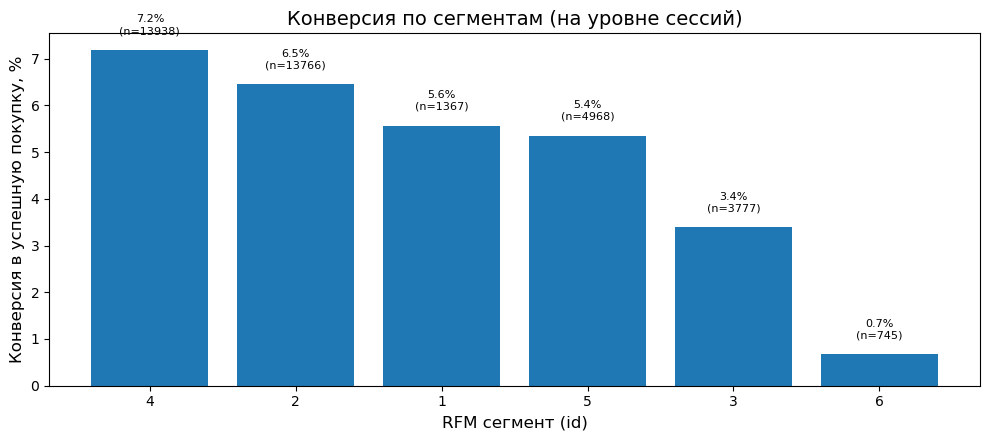

In [59]:
seg = seg_table.reset_index().copy()
seg["Конверсия"] *= 100

fig, ax = plt.subplots(figsize=(10,4.5))
ax.bar(seg["client_segment"].astype(str), seg["Конверсия"])
ax.set_xlabel("RFM сегмент (id)")
ax.set_ylabel("Конверсия в успешную покупку, %")
ax.set_title("Конверсия по сегментам (на уровне сессий)")
for x, y, n in zip(seg["client_segment"].astype(str), seg["Конверсия"], seg["Сессий"]):
    ax.text(x, y+0.3, f"{y:.1f}%\n(n={n})", ha="center", va="bottom", fontsize=8)
fig.tight_layout()
plt.show()

In [60]:
top_channels = sess["session_channel"].value_counts().head(8).index.tolist()
chan_table = (sess[sess["session_channel"].isin(top_channels)]
              .groupby("session_channel")["purchase_success"]
              .agg(Сессий="count", Конверсия="mean")
              .sort_values("Конверсия", ascending=False))
chan_table

,Сессий,Конверсия
session_channel,,
banner,1912,0.071653
Google,3891,0.066050
email,1912,0.065900
UTM-метки Выгоды,1925,0.061299
Неизвестно,19263,0.061257
Bing,1904,0.059349
Сторис,3807,0.057526
Яндекс,3947,0.054218


In [62]:
purchase = df[df["session_purchase_status"]=="Успешные"].groupby("session_id").agg({
    "session_purchase_price": "max",
    "session_purchase_tickets_num": "max",
    "session_purchase_tickets_luggage_flg": lambda x: x.dropna().iloc[0] if x.dropna().size else np.nan,
    "session_purchase_tickets_class_of_service": lambda x: x.dropna().iloc[0] if x.dropna().size else np.nan,
})

display(purchase[["session_purchase_price","session_purchase_tickets_num"]].describe(percentiles=[.25,.5,.75,.9,.95,.99]))
display(purchase["session_purchase_tickets_num"].value_counts().head(10))
display(purchase["session_purchase_tickets_luggage_flg"].value_counts(normalize=True))
display(purchase["session_purchase_tickets_class_of_service"].value_counts(normalize=True))

,session_purchase_price,session_purchase_tickets_num
count,2364.000000,2364.000000
mean,15039.170372,1.577411
std,16220.836157,1.004609
min,1132.410000,1.000000
25%,6254.005000,1.000000
50%,10557.650000,1.000000
75%,17901.072500,2.000000
90%,29058.750000,3.000000
95%,41824.033000,3.000000
99%,77926.560700,6.000000


session_purchase_tickets_num
1.0     1482
2.0      605
3.0      177
4.0       52
5.0       18
6.0       16
8.0        7
7.0        5
10.0       1
11.0       1
Name: count, dtype: int64

session_purchase_tickets_luggage_flg
Без багажа    0.751692
С багажом     0.248308
Name: proportion, dtype: float64

session_purchase_tickets_class_of_service
Эконом    0.994924
Бизнес    0.005076
Name: proportion, dtype: float64